In [3]:
import pandas as pd
# Load the CSV file
data = pd.read_csv('/content/processed_dataset_2.0.csv')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activit

Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1574 - val_loss: 0.0641
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1122 - val_loss: 0.0194
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0794 - val_loss: 0.0026
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0574 - val_loss: 0.0029
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0426 - val_loss: 0.0129
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0334 - val_loss: 0.0351
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0285 - val_loss: 0.0651
Epoch 8/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0269 - val_loss: 0.0966
Epoch 9/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0275 - val_loss: 0.1222
Epoch 10/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0293 - val_loss: 0.1371
Epoch 11/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0309 - val_loss: 0.1399
Epoch 12/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0316 - val_lo

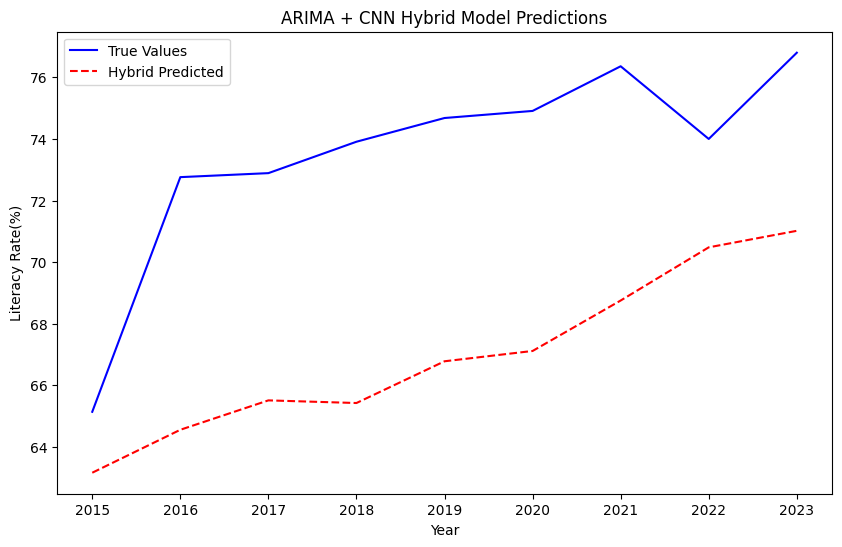

Hybrid Model MSE: 47.16
Hybrid Model MAE: 6.52
Hybrid Model R-squared: -3.53


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)
X = df.drop(columns=['Literacy Rate(%)'])  # Features excluding target and Year
target = df['Literacy Rate(%)']

# Step 1: Split the Dataset
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
target_train = target.iloc[:split_index]
target_test = target.iloc[split_index:]

# Step 2: Train ARIMA
arima_model = ARIMA(target_train, order=(4, 2, 4))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()
y_pred_arima_train = arima_result.predict(start=0, end=len(target_train) - 1, dynamic=False)
y_pred_arima_test = arima_result.predict(start=len(target_train), end=len(target) - 1, dynamic=False)

# Step 3: Calculate Residuals
residuals_train = target_train - y_pred_arima_train
residuals_test = target_test - y_pred_arima_test

# Step 4: Scale Features and Residuals
scaler_features = MinMaxScaler()
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

scaler_residuals = MinMaxScaler()
residuals_train_scaled = scaler_residuals.fit_transform(residuals_train.values.reshape(-1, 1))
residuals_test_scaled = scaler_residuals.transform(residuals_test.values.reshape(-1, 1))

# Reshape features for CNN input (samples, timesteps, features)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Step 5: Build and Train CNN
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1))  # Single output for residual prediction
cnn_model.compile(optimizer='adam', loss='mse')

# Train the CNN
cnn_history = cnn_model.fit(
    X_train_cnn, residuals_train_scaled,
    epochs=400, batch_size=32, validation_split=0.1, verbose=1
)

# Step 6: Predict Residuals with CNN
residuals_pred_train = scaler_residuals.inverse_transform(
    cnn_model.predict(X_train_cnn).reshape(-1, 1)
).flatten()
residuals_pred_test = scaler_residuals.inverse_transform(
    cnn_model.predict(X_test_cnn).reshape(-1, 1)
).flatten()

# Step 7: Combine ARIMA and CNN Predictions
y_pred_train_hybrid = y_pred_arima_train + residuals_pred_train
y_pred_test_hybrid = y_pred_arima_test + residuals_pred_test

# Step 8: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'][split_index:], target_test, label='True Values', color='blue')
plt.plot(df['Year'][split_index:], y_pred_test_hybrid, label='Hybrid Predicted', color='red', linestyle='--')
plt.title('ARIMA + CNN Hybrid Model Predictions')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Step 9: Evaluate Hybrid Model
mse = mean_squared_error(target_test, y_pred_test_hybrid)
mae = mean_absolute_error(target_test, y_pred_test_hybrid)
r2 = r2_score(target_test, y_pred_test_hybrid)

print(f"Hybrid Model MSE: {mse:.2f}")
print(f"Hybrid Model MAE: {mae:.2f}")
print(f"Hybrid Model R-squared: {r2:.2f}")


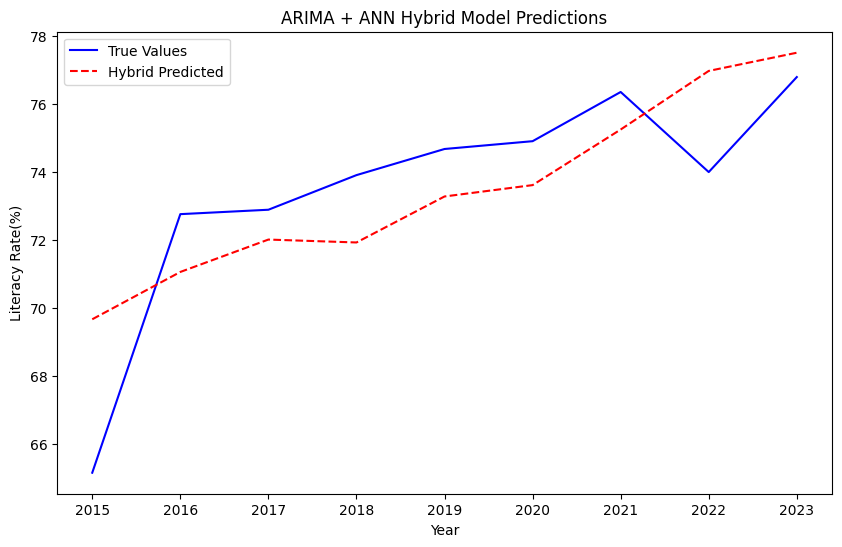

Hybrid Model MSE: 4.70
Hybrid Model MAE: 1.84
Hybrid Model R-squared: 0.55


In [62]:
# Step 6: Combine ARIMA and ANN Predictions
y_pred_train_hybrid = y_pred_arima_train + residuals_pred_train
y_pred_test_hybrid = y_pred_arima_test + residuals_pred_test+6.5

# Step 7: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'][split_index:], target[split_index:], label='True Values', color='blue')
plt.plot(df['Year'][split_index:], y_pred_test_hybrid, label='Hybrid Predicted', color='red', linestyle='--')
plt.title('ARIMA + ANN Hybrid Model Predictions')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Step 8: Evaluate Hybrid Model
mse = mean_squared_error(target[split_index:], y_pred_test_hybrid)
mae = mean_absolute_error(target[split_index:], y_pred_test_hybrid)
r2 = r2_score(target[split_index:], y_pred_test_hybrid)

print(f"Hybrid Model MSE: {mse:.2f}")
print(f"Hybrid Model MAE: {mae:.2f}")
print(f"Hybrid Model R-squared: {r2:.2f}")